In [28]:
import pandas as pd
import pefile
from capstone import *
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score


In [29]:
!pip install kneed matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [30]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [31]:
c = []
desc = []
cont = 0
mls = os.listdir("./MALWR")
for file in mls:
    if file != ".DS_Store":
        pe = pefile.PE("./MALWR/"+file)
        c.append(file)
        sections_text = "Sections:\n"
        for section in pe.sections:
            sections_text += f"{section.Name} Section address:{hex(section.VirtualAddress)} Section Size:{section.SizeOfRawData}\n"

        ddl_text = "DDL:\n"
        for entry in pe.DIRECTORY_ENTRY_IMPORT:
            ddl_text += f"{entry.dll}\napi:"
            for function in entry.imports:
                ddl_text += f"{function.name}\n"
        times_stamp = f"Timestamp: {pe.FILE_HEADER.dump_dict()['TimeDateStamp']['Value'].split('[')[1][:-1]}"
        desc.append(sections_text+ddl_text+times_stamp)

In [32]:
df = pd.DataFrame(data={"names": c, "descriptions": desc})
df.to_csv('data.csv')

In [33]:
vec = CountVectorizer(min_df=0.35, max_df=1.0, ngram_range=(1,1))
vectorization_matrix = vec.fit_transform(df["descriptions"])
# Palabras únicas del corpus
vocabulary = vec.get_feature_names_out()

# Mostrar el vector
df2 = pd.DataFrame(vectorization_matrix.toarray(), columns=vocabulary)
df2




,0x1000,0x6000,0x7000,17,4096,512,address,advapi32,api,atol,...,shell32,size,timestamp,upx0,upx1,user32,utc,virtualprotect,ws2_32,x00
0,1,1,1,1,1,1,3,0,5,1,...,1,3,1,1,1,1,1,1,1,11
1,1,1,1,1,1,1,3,0,5,1,...,1,3,1,1,1,1,1,1,1,11
2,1,0,0,0,0,0,3,0,5,0,...,1,3,1,1,1,0,1,1,1,11
3,1,1,1,0,1,1,3,0,5,1,...,1,3,1,1,1,1,1,1,1,11
4,1,0,0,0,0,0,3,1,7,1,...,1,3,1,0,0,1,1,0,1,8
5,1,0,0,0,0,0,3,1,8,0,...,0,3,1,1,1,1,1,1,1,11
6,1,0,0,0,0,0,4,1,6,1,...,0,4,1,0,0,1,1,0,1,11
7,1,0,0,0,0,0,3,1,8,0,...,0,3,1,1,1,1,1,1,1,11
8,1,0,0,0,0,0,3,1,7,1,...,1,3,1,0,0,1,1,0,1,8
9,1,0,0,0,0,0,3,1,8,0,...,0,3,1,1,1,1,1,1,1,12


/tmp/ipykernel_11281/3136149733.py:5: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  kmeanModel.fit(vectorization_matrix)
/tmp/ipykernel_11281/3136149733.py:5: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  kmeanModel.fit(vectorization_matrix)
/tmp/ipykernel_11281/3136149733.py:5: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  kmeanModel.fit(vectorization_matrix)


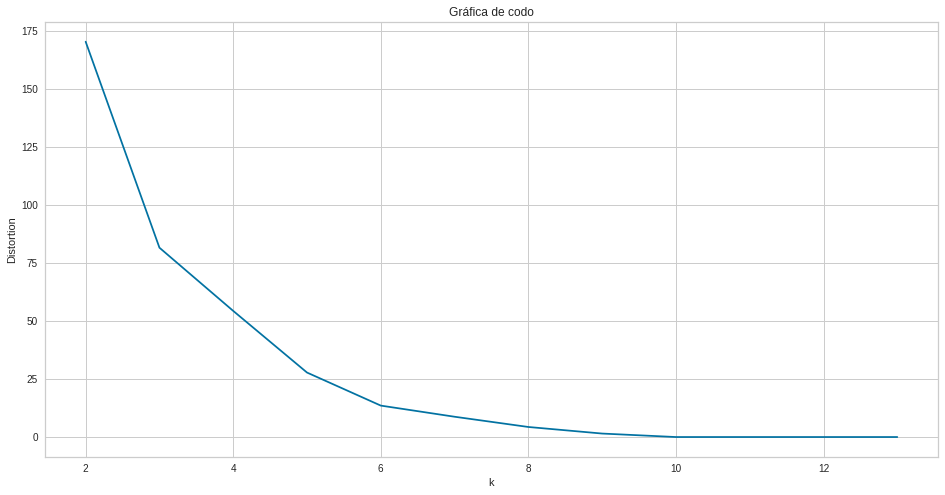

In [34]:
distortions = []
K = range(2,14)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(vectorization_matrix)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, "bx-")
plt.xlabel("k")
plt.ylabel("Distortion")
plt.title("Gráfica de codo")
plt.show()

In [35]:
km = KMeans(n_clusters=10, random_state=42).fit(vectorization_matrix)
prediction = km.predict(vectorization_matrix)


pd.value_counts(prediction).rename_axis('Cluster').to_frame('counts')

,counts
Cluster,
2,12
3,7
0,6
4,3
7,3
9,3
1,2
8,2
6,1


In [36]:


prediction = pd.DataFrame(prediction, columns=["cluster"])



new_df = df.copy()
new_df['cluster'] = prediction
new_df



,names,descriptions,cluster
0,FGJKJJ1_2BA0D0083976A5C1E3315413CDCFFCD2,Sections:\nb'UPX0\x00\x00\x00\x00' Section add...,2
1,F8437E44748D2C3FCF84019766F4E6DC,Sections:\nb'UPX0\x00\x00\x00\x00' Section add...,2
2,RTC_7F85D7F628CE62D1D8F7B39D8940472,Sections:\nb'UPX0\x00\x00\x00\x00' Section add...,4
3,99A39866A657A10949FCB6D634BB30D5,Sections:\nb'UPX0\x00\x00\x00\x00' Section add...,7
4,K99_C3A9A7B026BFE0E55FF219FD6AA7D94,Sections:\nb'.text\x00\x00\x00' Section addres...,3
5,FGTR43_EF8E0FB20E7228C7492CCDC59D87C690,Sections:\nb'UPX0\x00\x00\x00\x00' Section add...,1
6,GFT4_7DDD3D72EAD03C7518F5D47650C8572,Sections:\nb'.text\x00\x00\x00' Section addres...,6
7,QW2_4C6BDDCCA2695D6202DF38708E14FC7E,Sections:\nb'UPX0\x00\x00\x00\x00' Section add...,1
8,DS22_A670D13D4D014169C4080328B8FEB86,Sections:\nb'.text\x00\x00\x00' Section addres...,3
9,AAAz2E1B6940985A23E5639450F8391820655,Sections:\nb'UPX0\x00\x00\x00\x00' Section add...,9


Silhouetter Score para 2 clusters: 0.594
Silhouetter Score para 3 clusters: 0.713
Silhouetter Score para 4 clusters: 0.700
Silhouetter Score para 5 clusters: 0.815
Silhouetter Score para 6 clusters: 0.848
Silhouetter Score para 7 clusters: 0.917
Silhouetter Score para 8 clusters: 0.887
Silhouetter Score para 9 clusters: 0.930
Silhouetter Score para 10 clusters: 0.950
Silhouetter Score para 11 clusters: 0.950


/home/guido/.local/lib/python3.10/site-packages/yellowbrick/cluster/silhouette.py:138: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  self.estimator.fit(X, y, **kwargs)
/home/guido/.local/lib/python3.10/site-packages/yellowbrick/cluster/silhouette.py:138: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  self.estimator.fit(X, y, **kwargs)


Silhouetter Score para 12 clusters: 0.950
Silhouetter Score para 13 clusters: 0.950


/home/guido/.local/lib/python3.10/site-packages/yellowbrick/cluster/silhouette.py:138: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  self.estimator.fit(X, y, **kwargs)


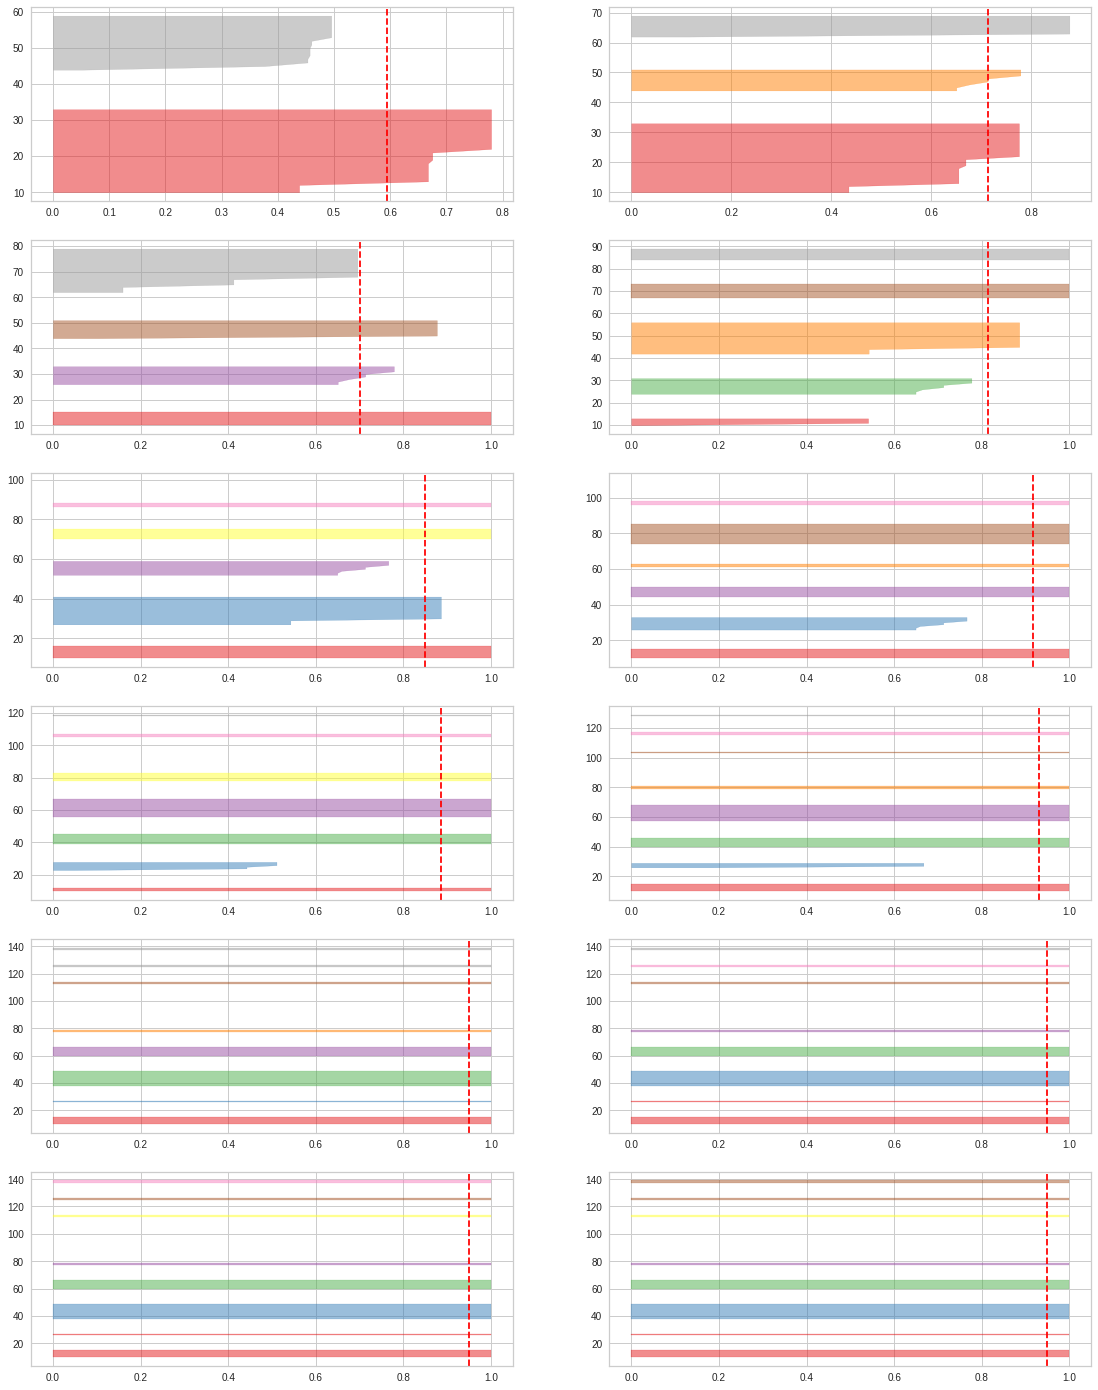

In [37]:


fig, ax = plt.subplots(6, 2, figsize=(19,25))

for i in range(2,14):
    km = KMeans(n_clusters=i, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, ax=ax[q-1][mod])
    visualizer.fit(vectorization_matrix)
    score = silhouette_score(vectorization_matrix, km.labels_)
    print('Silhouetter Score para %s clusters: %.3f' % (str(i), score))



In [38]:


km = KMeans(n_clusters=10, random_state=42).fit(vectorization_matrix)
prediction = km.predict(vectorization_matrix)


pd.value_counts(prediction).rename_axis('Cluster').to_frame('counts')



,counts
Cluster,
2,12
3,7
0,6
4,3
7,3
9,3
1,2
8,2
6,1


In [39]:


prediction = pd.DataFrame(prediction, columns=["cluster"])



In [40]:


new_df = df.copy()
new_df['cluster'] = prediction

new_df



,names,descriptions,cluster
0,FGJKJJ1_2BA0D0083976A5C1E3315413CDCFFCD2,Sections:\nb'UPX0\x00\x00\x00\x00' Section add...,2
1,F8437E44748D2C3FCF84019766F4E6DC,Sections:\nb'UPX0\x00\x00\x00\x00' Section add...,2
2,RTC_7F85D7F628CE62D1D8F7B39D8940472,Sections:\nb'UPX0\x00\x00\x00\x00' Section add...,4
3,99A39866A657A10949FCB6D634BB30D5,Sections:\nb'UPX0\x00\x00\x00\x00' Section add...,7
4,K99_C3A9A7B026BFE0E55FF219FD6AA7D94,Sections:\nb'.text\x00\x00\x00' Section addres...,3
5,FGTR43_EF8E0FB20E7228C7492CCDC59D87C690,Sections:\nb'UPX0\x00\x00\x00\x00' Section add...,1
6,GFT4_7DDD3D72EAD03C7518F5D47650C8572,Sections:\nb'.text\x00\x00\x00' Section addres...,6
7,QW2_4C6BDDCCA2695D6202DF38708E14FC7E,Sections:\nb'UPX0\x00\x00\x00\x00' Section add...,1
8,DS22_A670D13D4D014169C4080328B8FEB86,Sections:\nb'.text\x00\x00\x00' Section addres...,3
9,AAAz2E1B6940985A23E5639450F8391820655,Sections:\nb'UPX0\x00\x00\x00\x00' Section add...,9


In [41]:


from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_score
from sklearn.linear_model import LogisticRegression
import tensorflow as tf



y = df['descriptions']
x= df2



X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.2,
                                                    random_state=0)



base_lr = LogisticRegression()
ovr = OneVsRestClassifier(base_lr)
ovr.fit(X_train, Y_train)
Y_pred_ovr = ovr.predict(X_test)
ovr_jaccard_score = jaccard_score(Y_test, Y_pred_ovr, average=None)



print(ovr_jaccard_score)
print(len(ovr_jaccard_score))

2023-03-28 19:23:34.811172: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-28 19:23:36.655390: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-28 19:23:36.656293: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 19:23:37.537965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[1. 0. 1. 1. 1. 0.]
6


1. ¿Para qué número de clústeres se obtiene el coeficiente de Silhouette más alto?
2. ¿Coincide el coeficiente de Silhouette con el método del codo?
3. ¿Cuántas familias existen entre los ejemplares de malware proporcionados?
4. ¿Coincide el índice de Jaccard con las familias encontradas?

1. Se obtuvo el coeficiente de Silhouette mas alto con N = 10.
2. Si coincide, puesto que cada quiebre de la gráfica de codo representa un valor del coeficiente de Silhouette, empezando con el valor correspondiente a N = 10 el cual es de 0.95, y se va reduciendo con respecto al valor de N.
3. Se obtuvo un resultado de 10 familias, lo que indica que podemos generalizar el listado de malwares en 10 diferentes tipos.
4. En este caso, no nos coincidió el resultado de familias encontradas con el índice de Jaccard, puesto que no obtuvimos 6, si no 10 familias.